
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [25 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [4]:
# your code here

min_vals = X_train.min()
max_vals = X_train.max()

X_train = (X_train - min_vals)/(max_vals - min_vals)
X_test = (X_test - min_vals)/(max_vals - min_vals)

**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [5]:
# your code here

# fitting multi regression model
multi_regr = LogisticRegression(C=100000, solver = "lbfgs", max_iter=10000, random_state=109)
multi_regr.fit(X_train, y_train)

# predictions
y_train_pred_multi = multi_regr.predict(X_train) 
y_test_pred_multi = multi_regr.predict(X_test)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test, y_test_pred_multi)

print('Training set accuracy for multiple logistic regression = ', train_score_multi)
print('Test set accuracy for multiple logistic regression = ', test_score_multi)

Training set accuracy for multiple logistic regression =  1.0
Test set accuracy for multiple logistic regression =  0.7814569536423841


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [6]:
# your code here

# fitting regularized multi regression model - L1 penalty
# Any reason for using liblinear  - Use 5 fold CV
logit_regr_lasso = LogisticRegressionCV( solver='liblinear', penalty='l1', cv=5)
logit_regr_lasso.fit(X_train, y_train)

# predictions
y_train_pred_lasso = logit_regr_lasso.predict(X_train) 
y_test_pred_lasso = logit_regr_lasso.predict(X_test)

# accuracy
train_score_lasso = accuracy_score(y_train, y_train_pred_lasso)
test_score_lasso = accuracy_score(y_test, y_test_pred_lasso)

print('Training set accuracy for multiple logistic regression = ', train_score_lasso)
print('Test set accuracy for multiple logistic regression = ', test_score_lasso)

Training set accuracy for multiple logistic regression =  0.9101497504159733
Test set accuracy for multiple logistic regression =  0.8609271523178808


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [7]:
# your code here

knn_scores = []
ks = [1,2,3,4,5,7,9,10,15,25]

for k in ks:
    knn = KNeighborsClassifier(k)
    knn_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))

pd.DataFrame(knn_scores,ks)

,0
1,0.815334
2,0.801945
3,0.865310
4,0.835391
5,0.856907
7,0.875172
9,0.871783
10,0.848614
15,0.831863
25,0.745468


In [8]:
knn7 = KNeighborsClassifier(7)
knn7.fit(X_train,y_train)

# predictions
y_train_pred_knn = knn7.predict(X_train) 
y_test_pred_knn = knn7.predict(X_test)

# accuracy
train_score_knn = accuracy_score(y_train, y_train_pred_knn)
test_score_knn = accuracy_score(y_test, y_test_pred_knn)

print('Training set accuracy for knn(7) = ', train_score_knn)
print('Test set accuracy for knn(7) = ', test_score_knn)

Training set accuracy for knn(7) =  0.9018302828618968
Test set accuracy for knn(7) =  0.8609271523178808


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [9]:
# your code here

print('Confusion matrix for multiple logistic regression')
print(metrics.confusion_matrix(y_test, y_test_pred_multi))

print('Confusion matrix for regularized logistic regression')
print(metrics.confusion_matrix(y_test, y_test_pred_lasso))

print('Confusion matrix for knn')
print(metrics.confusion_matrix(y_test, y_test_pred_knn))

Confusion matrix for multiple logistic regression
[[65 12]
 [21 53]]
Confusion matrix for regularized logistic regression
[[67 10]
 [11 63]]
Confusion matrix for knn
[[67 10]
 [11 63]]


For the full logistic regression model, there are 12 false positives and 21 false negatives, and for the LASSO-like logistic regression model, there are 10 false positives and 11 false negatives, and knn-7 has one more false negative compared to LASSO.  The full logistic regression model has a tougher time predicting what are truly 'positives' here, but actually underperforms in both classes compared to the other two models considered.

<div class='exercise'><b> Question 2 [25 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [10]:
# your code here

# standardizing before PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
display(X_train.describe())

pca = PCA().fit(X_train)
pca_xtrain = pca.transform(X_train)
pca_xtest = pca.transform(X_test)

print(pca.components_.shape)
print("pca shape in train:", pca_xtrain.shape, "and pca shape in test:", pca_xtest.shape)

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,...,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,...,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02,6.010000e+02
mean,2.964905e-16,-1.921185e-16,9.338066e-17,2.866075e-16,-3.630161e-16,-3.068353e-16,-1.906406e-16,4.747543e-16,3.596679e-16,5.281410e-16,-4.957095e-17,2.349757e-16,...,-3.790645e-16,-2.939043e-16,-1.956283e-16,-2.459670e-16,3.128391e-16,-7.204442e-18,-3.339906e-16,2.268476e-16,-1.721677e-16,8.368237e-17,-4.285719e-17,3.450743e-16
std,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,...,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00,1.000833e+00
min,-4.570373e+00,-4.959110e+00,-3.236778e+00,-3.133268e+00,-4.370112e+00,-2.629677e+00,-3.819691e+00,-3.317173e+00,-4.839954e+00,-3.552995e+00,-3.704261e+00,-2.800073e+00,...,-3.035214e+00,-3.236052e+00,-4.018121e+00,-3.264515e+00,-2.963576e+00,-3.889263e+00,-3.586451e+00,-3.648457e+00,-2.669117e+00,-3.096615e+00,-3.475253e+00,-3.005005e+00
25%,-6.262139e-01,-5.816676e-01,-5.854528e-01,-6.133846e-01,-6.278169e-01,-6.214191e-01,-5.878085e-01,-7.019759e-01,-5.472234e-01,-5.979849e-01,-5.345481e-01,-6.299041e-01,...,-6.296126e-01,-6.368791e-01,-5.690696e-01,-6.571205e-01,-6.098184e-01,-5.650560e-01,-5.148769e-01,-6.740868e-01,-6.503100e-01,-5.765545e-01,-5.945330e-01,-6.844021e-01
50%,6.291073e-02,7.965581e-02,-2.582551e-02,-1.204226e-02,8.682020e-02,-1.065262e-01,-2.888872e-02,7.920189e-02,8.819168e-02,1.265591e-02,1.187794e-01,7.704837e-02,...,-6.930976e-02,-1.673876e-02,-5.159025e-02,-5.215029e-02,3.784034e-02,-6.865438e-02,1.407065e-01,-8.569185e-02,-8.932283e-02,-9.789289e-03,-1.058029e-01,-1.444010e-02
75%,6.517121e-01,6.378469e-01,4.878221e-01,5.992771e-01,6.419955e-01,5.858109e-01,6.529576e-01,7.003272e-01,6.632805e-01,5.328147e-01,6.477601e-01,6.921257e-01,...,6.777492e-01,6.275691e-01,6.141623e-01,7.006727e-01,6.032079e-01,5.070604e-01,6.537007e-01,5.739112e-01,5.205509e-01,6.327527e-01,6.234525e-01,6.210007e-01
max,3.711081e+00,2.893450e+00,3.476187e+00,4.007661e+00,2.692999e+00,3.883399e+00,2.637033e+00,2.774772e+00,2.950490e+00,3.508377e+00,2.543571e+00,3.725361e+00,...,2.615610e+00,3.539761e+00,3.178823e+00,3.448861e+00,3.136587e+00,6.042372e+00,2.482522e+00,3.591428e+00,4.534747e+00,3.114761e+00,2.991783e+00,3.507011e+00


(601, 7129)
pca shape in train: (601, 601) and pca shape in test: (151, 601)


*Your answer here*

The limiting factor is the number of rows (601). The number of PCA components is 601 even though there are a lot more columns. Number of PCA components = min(#rows, #columns)

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

(601, 3)


,PCA1,PCA2,Cancer_type
0,-3.973727,-2.520476,1.0
1,-12.846391,-13.730848,1.0
2,-14.528682,-16.687931,1.0
3,6.946585,-15.469188,1.0
4,0.893353,-14.311994,1.0


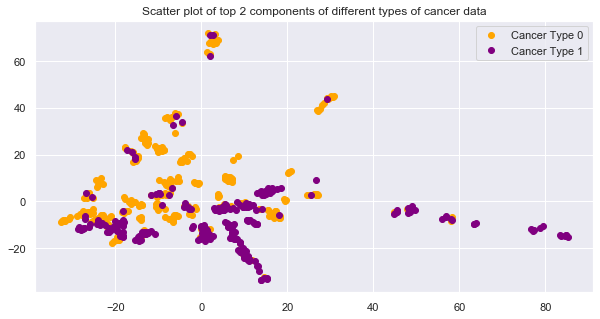

In [11]:
# your code here

# generating scatter plot
pca_df = pd.DataFrame(pca_xtrain[:,0:2], columns=['PCA1', 'PCA2'])
pca_df['Cancer_type'] = y_train.values

print(pca_df.shape)
display(pca_df.head())

# plotting 2 PCs
fig, ax = plt.subplots(figsize=(10,5))
type_0 = pca_df[pca_df['Cancer_type'] == 0]
type_1 = pca_df[pca_df['Cancer_type'] == 1]
ax.plot(type_0['PCA1'], type_0['PCA2'],  'o', color='orange', label='Cancer Type 0')
ax.plot(type_1['PCA1'], type_1['PCA2'],  'o', color='purple', label='Cancer Type 1')
ax.set_title('Scatter plot of top 2 components of different types of cancer data')
ax.legend();

*your answer here*

2-dimensional PCA is a useful visualization because: 

1. You can't plot a high-dimensional space in the same dimensions
2. You can see whether the classes are separable in 2-dimensions to get a sense of what it would be like in higher dimensions
3. The first 2 components may be a good approximation for the data (if they explain a decent proportion of the variance).
4. In a classification problem, we can see if the classes are somewhat separable or clustered together in 2-dimensions to gauge whether the classes are perhaps separable in general

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

Variance explained: 0.11219678772764466
number of components that explain at least 90% of the variance= 233


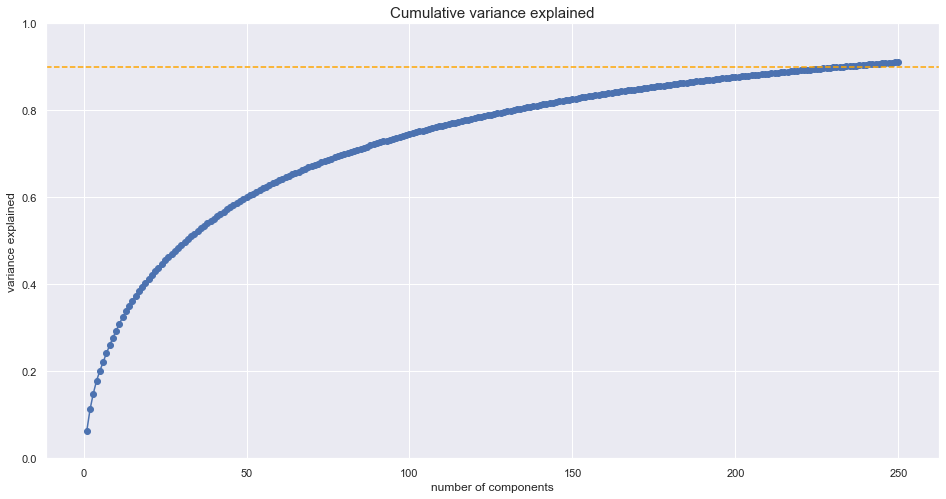

In [12]:
# your code here

print( "Variance explained:", np.sum(pca.explained_variance_ratio_[0:2]))

# finding top 2 components
var_explained = []
total_comp = 250
pca = PCA(n_components = total_comp).fit(X_train)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(range(1, total_comp+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.axhline(0.9, linestyle='--', color='orange')
ax.set_ylim(0,1)
ax.set_xlabel('number of components')
ax.set_ylabel('variance explained')
ax.set_title('Cumulative variance explained',fontsize=15)

print("number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<=0.9)[0])+1)

**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony.**

Number of principal components chosen: 16


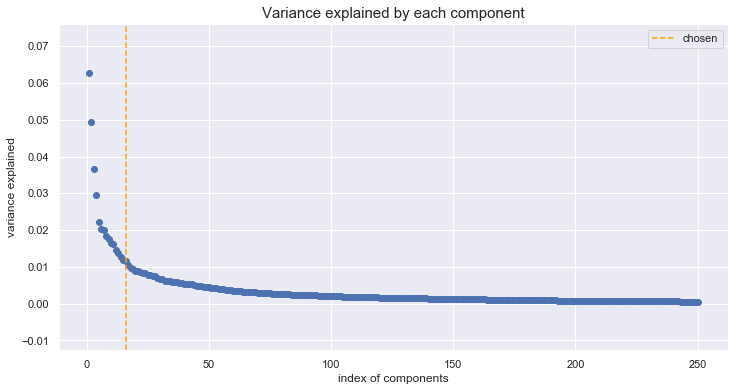

In [13]:
#your code here

# choosing PCs that explain more than 0.01 of the variance
chosen = np.where(pca.explained_variance_ratio_ < 1e-2)[0][0] - 1
print('Number of principal components chosen: {}'.format(chosen))

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
ax.set_xlabel('index of components')
ax.set_ylabel('variance explained')
ax.set_title('Variance explained by each component',fontsize=15)
ax.axvline(chosen, linestyle='--', label='chosen', color='orange')
ax.legend();

The above is one reasonable way of choosing a reasonable number of principal components (based on how much of the variance they explain). If they explain greater than 0.01 of the variance, they are chosen.

<div class='exercise'><b> Question 3 [25 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [14]:
# your code here

components = [2, chosen, 232]
models = [multi_regr, logit_regr_lasso, knn7]
preds = [y_test_pred_multi, y_test_pred_lasso, y_test_pred_knn]
scores = [[train_score_multi, test_score_multi], [train_score_lasso, test_score_lasso], 
          [train_score_knn, test_score_knn]]

for i, component in enumerate(components):
    pca = PCA(n_components = component).fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    logreg_pca = LogisticRegression(C=100000, fit_intercept=False, solver='lbfgs', max_iter=10000)
    logreg_pca.fit(X_train_pca, y_train)
    
    y_train_pred_logreg_pca = logreg_pca.predict(X_train_pca)
    y_test_pred_logreg_pca = logreg_pca.predict(X_test_pca)
    
    # append the model to the list of models
    models.append(logreg_pca)
    preds.append(y_test_pred_logreg_pca)

    train_score = accuracy_score(y_train, y_train_pred_logreg_pca)
    test_score = accuracy_score(y_test, y_test_pred_logreg_pca)
    
    scores.append([train_score, test_score])

names = ['Multiple Logistic Regression', 'Regularized Logistic Regression', 'kNN',
         '2 components PCA', '{} components PCA'.format(chosen), '232 components PCA',]

df_res = pd.DataFrame(scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_res

,Train Accuracy,Test Accuracy
Multiple Logistic Regression,1.000000,0.781457
Regularized Logistic Regression,0.910150,0.860927
kNN,0.901830,0.860927
2 components PCA,0.783694,0.794702
16 components PCA,0.891847,0.860927
232 components PCA,1.000000,0.741722


*your answer here*

- kNN, Regularized Logistic Regression and 16 component PCA are similar
- The model with 16 principal components does similarly on the training and test sets and does better than an unregularized model that is fit on the entire training set.
- The model with 232 parameters is overfit, and has a performance comparable with the unregularized model.
- The model with 2 components actually does reasonably well on the test set
- The regularized logistic regression model on all the predictors (from question 1) is the best model

**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [15]:
# your code here

cv_scores = []
pcs = [2, chosen, 232]

for pc in pcs:
    pca = PCA(n_components = pc).fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    logreg_pca = LogisticRegression(C=100000, fit_intercept=False, solver='lbfgs', max_iter=10000)
    logreg_pca.fit(X_train_pca, y_train)
    
    cv_scores.append(np.mean(cross_val_score(logreg_pca, X_train_pca, y_train, cv=5)))

pd.DataFrame(cv_scores, index=names[3:], columns=['CV Score'])

,CV Score
2 components PCA,0.771831
16 components PCA,0.880242
232 components PCA,0.745524


In [16]:
pca = PCA(n_components = 16).fit(X_train)
    
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
    
logreg_pca = LogisticRegression(C=100000, solver='lbfgs', max_iter=10000)
logreg_pca.fit(X_train_pca, y_train)

dot_prod = np.dot(logreg_pca.coef_, pca.components_[:16])
col_num = X_train.columns.values.tolist().index('M31523_at')
coef_m = dot_prod.flatten()[col_num]

print(coef_m)

-0.011536880004071388


- interpretation of the above number as a -0.011536880004071388 change in log-odds of `cancer_type` with a 1 unit increase in the `M31523_at`
- exponentiate the number to get a corresponding increase in odds. The change in odds is 0.988529415.

**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*

- a discussion between type-1 and type-2 errors and there being a trade-off between these two types of errors
- a high-level discussion of the ROC as a curve displaying the true positive rate on the y-axis and the false positive rate on the x-axis
- AUC is the area under this curve. An ideal curve has a large area i.e. is close to the top-left corner
- difference between AUC and misclassification rate could talk about an emphasis on type-1 vs type-2 errors instead of simply accuracy over all samples
- This is a particular problem when our classes are imbalanced (i.e one class has way more points than the other class)

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [17]:
# your code here
auc_scores = []
for i, y_pred in enumerate(preds):
    auc_scores.append(metrics.roc_auc_score(y_test, y_pred))
    
df_res = pd.DataFrame(auc_scores, index=names, columns=['AUC Score'])
df_res

,AUC Score
Multiple Logistic Regression,0.780186
Regularized Logistic Regression,0.860741
kNN,0.860741
2 components PCA,0.795806
16 components PCA,0.860741
232 components PCA,0.741225


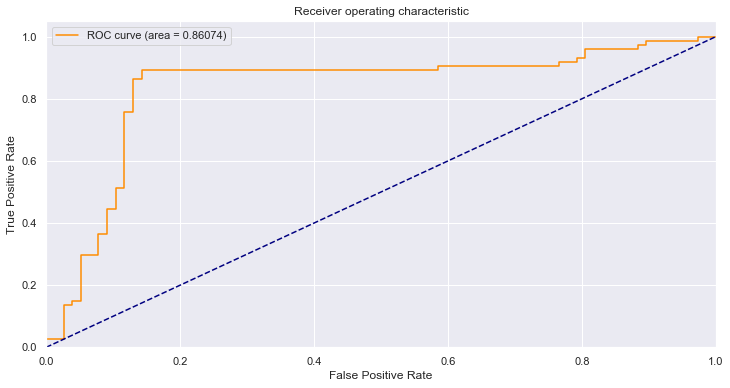

In [18]:
# choosing 16 component PCA because it is the simplest model in terms of number of predictors
model_ind = 4

# for plotting the AUC curve
preds_proba = []
pca = PCA(n_components = 16).fit(X_train)
X_test_pca = pca.transform(X_test)

y_test_pred_logreg_pca = models[model_ind].predict_proba(X_test_pca)
preds_proba.append(y_test_pred_logreg_pca)
preds_proba = np.array(preds_proba[0])[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba)

# plotting
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {})'.format(np.round(auc_scores[model_ind],5)))
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend();

*your answer here*

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*

- There are a lot of similar models based on the AUC
- You can use the model with the best AUC
- In real life, one type of cancer may be more severe than the other type of cancer. The relative severity of the different cancer types could suggest that we are ok with one type of error over the other (type-1 error vs type-2 error)
- bonus: use an ensemble of models to predict real cancer patients

**Additional Information**

Acute Lymphoblastic Leukemia (ALL):
- About 98% of children with ALL go into remission within weeks after starting treatment.
- About 90% of those children can be cured. Patients are considered cured after 10 years in remission.

Acute Myeloid Leukemia (AML):
- In general, children with AML are seen as lower risk than adults. 
- Around 85 to 90 percent of children with AML will go into remission after induction, according to the American Cancer Society. AML will return in some cases.  
- The five-year-survival-rate for children with AML is 60 to 70 percent.

<div class='exercise'><b> Question 4: COMPAS [25 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [19]:
compas_df = pd.read_csv('data/compas.csv')

# your code here
print(compas_df['sex'].value_counts())
compas_df['sex'] = (compas_df['sex'] == 'Male')*1
print(compas_df.shape)
display(compas_df.head())

Male      4997
Female    1175
Name: sex, dtype: int64
(6172, 23)


,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,69,F,Aggravated Assault w/Firearm,Other,Low,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
1,34,F,Felony Battery w/Prior Convict,African-American,Low,1,0,0,0,0,3,1,10,0,0,0,0,0,0,0,1,0,10
2,24,F,Possession of Cocaine,African-American,Low,1,4,0,0,1,4,1,1,0,1,0,0,0,1,1,0,0,1
3,44,M,Battery,Other,Low,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
4,41,F,Possession Burglary Tools,Caucasian,Medium,1,14,0,0,0,6,1,6,0,0,1,0,0,0,0,0,1,6


- One-hot encode some categorical predictors here such as sex

**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [20]:
# your code here
aa_df = compas_df[compas_df['race'] == 'African-American']
cc_df = compas_df[compas_df['race'] == 'Caucasian']

cols = aa_df.select_dtypes(include=np.number).columns.tolist()
p_vals = []

for i, col in enumerate(cols):
    aa = np.array(aa_df[col]).flatten()
    cc = np.array(cc_df[col]).flatten()
    t = ttest_ind(aa, cc, equal_var=False)
    p_val = t.pvalue
    p_vals.append(p_val)

p_vals = np.array(p_vals)
argsorted_pvals = np.argsort(p_vals)[:3]
chosen_cols = [cols[i] for i in argsorted_pvals]
print('Chosen Columns: {}'.format(chosen_cols))

Chosen Columns: ['decile_score', 'priors_count', 'age']


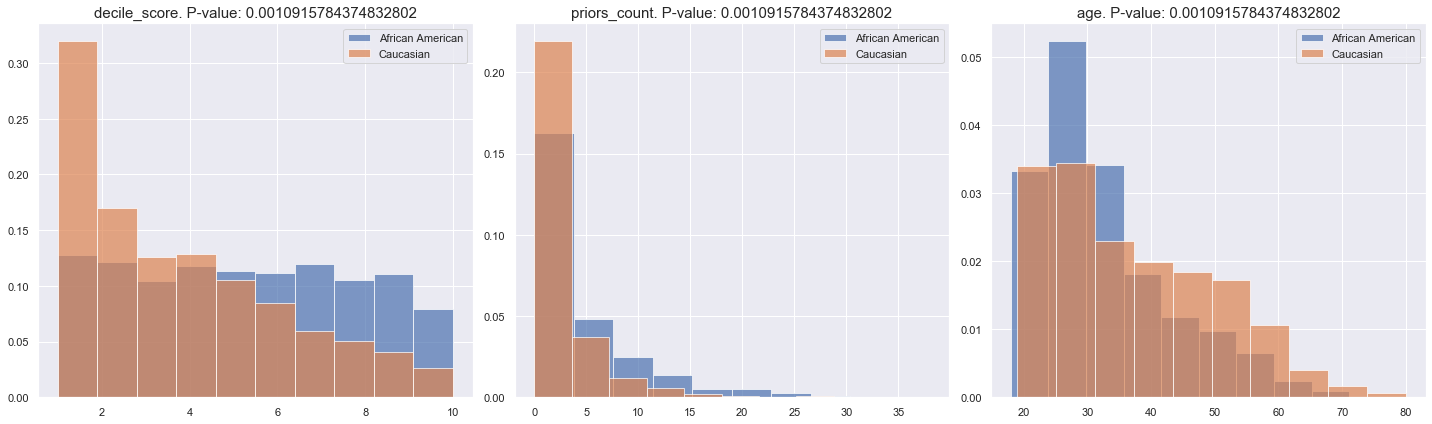

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
ax = ax.ravel()

for i, col in enumerate(chosen_cols):
    aa = np.array(aa_df[col]).flatten()
    cc = np.array(cc_df[col]).flatten()
    ax[i].hist(aa, label='African American', alpha=0.7, density=True)
    ax[i].hist(cc, label='Caucasian', alpha=0.7, density=True)
    ax[i].set_title('{}. P-value: {}'.format(col, p_val), fontsize=15)
    ax[i].legend()
fig.tight_layout()

- these histograms need to be normalized as the counts are different

**A CAVEAT**

A t-test is not the most suitable test for all these variables as they are not even close to being normally distributed. Using the coefficients of logistic regression (one for each race) and then determining differences between these models for the two races is another reasonable approach. Using groupBy in pandas and comparing proportions for binary predictors is also an acceptable approach. 

**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

*your answer here*

- bias in data collection: people added to the dataset for minor infractions as a result of their race i.e. perhaps through racial profiling in the system

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [22]:
# your code here

one_hot_df = pd.get_dummies(compas_df['race'], prefix='race', drop_first=True)
compas_race_df = pd.concat([compas_df.drop('race', axis=1), one_hot_df], axis=1)

# drop the object types
compas_race_df = compas_race_df.drop(['c_charge_degree', 'c_charge_desc', 'score_text'], axis=1)

data_train, data_test = train_test_split(compas_race_df, train_size=0.8, stratify=compas_df['race'], 
                                         random_state=109)

y_train = data_train['two_year_recid']
X_train = data_train.drop(['two_year_recid'], axis=1)

y_test = data_test['two_year_recid']
X_test = data_test.drop(['two_year_recid'], axis=1)

print(data_train.shape, data_test.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4937, 24) (1235, 24)
(4937, 23) (1235, 23) (4937,) (1235,)


In [23]:
logreg_model_recid = LogisticRegression(C=100000, solver = "lbfgs", max_iter=10000, random_state=109)
logreg_model_recid.fit(X_train, y_train)

y_pred_logreg_train = logreg_model_recid.predict(X_train)
y_pred_logreg_test = logreg_model_recid.predict(X_test)

print('Training set accuracy for log reg = ', accuracy_score(y_train, y_pred_logreg_train))
print('Test set accuracy for log reg = ', accuracy_score(y_test, y_pred_logreg_test))

knn_model_recid = KNeighborsClassifier(5).fit(X_train, y_train)

y_pred_knn_train = knn_model_recid.predict(X_train)
y_pred_knn_test = knn_model_recid.predict(X_test)

print('Training set accuracy for knn = ', accuracy_score(y_train, y_pred_knn_train))
print('Test set accuracy for knn = ', accuracy_score(y_test, y_pred_knn_test))

Training set accuracy for log reg =  0.6963743163864695
Test set accuracy for log reg =  0.6842105263157895
Training set accuracy for knn =  0.7607859023698602
Test set accuracy for knn =  0.6356275303643725


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [24]:
# your code here

# drop the object types and race
compas_norace_df = compas_df.drop(['c_charge_degree', 'c_charge_desc', 'score_text', 'race'], axis=1)
data_train_norace, data_test_norace = train_test_split(compas_norace_df, random_state=109,
                                                       train_size=0.8, stratify=compas_df['race'])

# re-splitting by the same random state and the same stratification so we get the same results as the 
# split for the previous sub-part
y_train_norace = data_train_norace['two_year_recid']
X_train_norace = data_train_norace.drop(['two_year_recid'], axis=1)

y_test_norace = data_test_norace['two_year_recid']
X_test_norace = data_test_norace.drop(['two_year_recid'], axis=1)

print(data_train_norace.shape, data_test_norace.shape)
print(X_train_norace.shape, X_test_norace.shape, y_train_norace.shape, y_test_norace.shape)

(4937, 19) (1235, 19)
(4937, 18) (1235, 18) (4937,) (1235,)


In [25]:
logreg_model_recid_norace = LogisticRegression(C=100000, solver = "lbfgs", max_iter=10000, random_state=109)
logreg_model_recid_norace.fit(X_train_norace, y_train_norace)

y_pred_logreg_train_norace = logreg_model_recid_norace.predict(X_train_norace)
y_pred_logreg_test_norace = logreg_model_recid_norace.predict(X_test_norace)

print('Training set accuracy for log reg (no race) = ',accuracy_score(y_train_norace, y_pred_logreg_train_norace))
print('Test set accuracy for log reg (no race) = ',accuracy_score(y_test_norace, y_pred_logreg_test_norace))

knn_model_recid_norace = KNeighborsClassifier(5).fit(X_train_norace, y_train_norace)

y_pred_knn_train_norace = knn_model_recid_norace.predict(X_train_norace)
y_pred_knn_test_norace = knn_model_recid_norace.predict(X_test_norace)

print('Training set accuracy for knn (no race) = ', accuracy_score(y_train_norace, y_pred_knn_train_norace))
print('Test set accuracy for knn (no race) = ', accuracy_score(y_test_norace, y_pred_knn_test_norace))

Training set accuracy for log reg (no race) =  0.6959692120721086
Test set accuracy for log reg (no race) =  0.6874493927125506
Training set accuracy for knn (no race) =  0.7611910066842212
Test set accuracy for knn (no race) =  0.6388663967611335


In [26]:
X_test = X_test.reset_index()
aa_ind = X_test[(X_test['race_Asian'] == 0) & (X_test['race_Caucasian'] == 0) 
                & (X_test['race_Other'] == 0) & (X_test['race_Native American'] == 0)].index.tolist()

aa_ind = np.array(aa_ind)
cc_ind = np.array(X_test[X_test['race_Caucasian'] == 1].index.tolist())

# false positives and true positives on model with race
print('Confusion Matrix for Logistic Regression Model with Race: African Americans')
print(metrics.confusion_matrix(np.array(y_test)[aa_ind], np.array(y_pred_logreg_test)[aa_ind]))

print('Confusion Matrix for Logistic Regression Model with Race: Caucasian')
print(metrics.confusion_matrix(np.array(y_test)[cc_ind], np.array(y_pred_logreg_test)[cc_ind]))

print('Confusion Matrix for kNN Model with Race: African Americans')
print(metrics.confusion_matrix(np.array(y_test)[aa_ind], np.array(y_pred_knn_test)[aa_ind]))

print('Confusion Matrix for kNN Model with Race: Caucasian')
print(metrics.confusion_matrix(np.array(y_test)[cc_ind], np.array(y_pred_knn_test)[cc_ind]))

Confusion Matrix for Logistic Regression Model with Race: African Americans
[[258 112]
 [129 238]]
Confusion Matrix for Logistic Regression Model with Race: Caucasian
[[220  44]
 [ 77  80]]
Confusion Matrix for kNN Model with Race: African Americans
[[234 136]
 [139 228]]
Confusion Matrix for kNN Model with Race: Caucasian
[[203  61]
 [ 84  73]]


In [27]:
# false positives and true positives on model without race
print('Confusion Matrix for Logistic Regression Model with Race: African Americans')
print(metrics.confusion_matrix(np.array(y_test)[aa_ind], np.array(y_pred_logreg_test_norace)[aa_ind]))

print('Confusion Matrix for Logistic Regression Model with Race: Caucasian')
print(metrics.confusion_matrix(np.array(y_test)[cc_ind], np.array(y_pred_logreg_test_norace)[cc_ind]))

print('Confusion Matrix for kNN Model with Race: African Americans')
print(metrics.confusion_matrix(np.array(y_test)[aa_ind], np.array(y_pred_knn_test_norace)[aa_ind]))

print('Confusion Matrix for kNN Model with Race: Caucasian')
print(metrics.confusion_matrix(np.array(y_test)[cc_ind], np.array(y_pred_knn_test_norace)[cc_ind]))

Confusion Matrix for Logistic Regression Model with Race: African Americans
[[259 111]
 [126 241]]
Confusion Matrix for Logistic Regression Model with Race: Caucasian
[[221  43]
 [ 80  77]]
Confusion Matrix for kNN Model with Race: African Americans
[[237 133]
 [135 232]]
Confusion Matrix for kNN Model with Race: Caucasian
[[199  65]
 [ 84  73]]


- Rates are very similar to the model when race was included
- There is still a difference in FPR and TPR between the two races even when race is not explicitly included in the model, which indicates that a lot of predictors are related to race.

**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

*your answer here*

- Lots of variables correlate with race. Removing race does not remove the effects of race from the model.
- Omitting race does not solve the problem of false-positive rates and false-negative rates being different for the two different races in question

---